In [1]:
import numpy as np

from mintpy.objects import sensor
from mintpy.utils import ptime, readfile, utils as ut, writefile
from mintpy.objects.stack import timeseries
import matplotlib.pyplot as plt
import pandas as pd
import re

In [3]:
vert_filename = r'C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\timeseries_vert.h5';
common_dates = timeseries(vert_filename).get_date_list()
vert_ts,vert_ts_atr = readfile.read(vert_filename);

In [5]:

def get_TRE_lat_lon(TRE_point_ts_file):
    match = re.search(r'\(([\d\.-]+),\s*([\d\.-]+)\)', TRE_point_ts_file)
    lat = 0.0;lon=0.0;
    if match:
        lat = float(match.group(1))
        lon = float(match.group(2))
        print(f"Latitude: {lat}, Longitude: {lon}")
    else:
        print("Coordinates not found in the file name.")
    return lat,lon

#TRE_point_ts_file = r'C:\Users\bvarugu\Downloads\Interpolated Vertical Displacement (ft) at (35.06140, -119.09532).csv'
#TRE_point_ts_file = r'C:\Users\bvarugu\Downloads\Interpolated Vertical Displacement (ft) at (35.20392, -118.95852).csv'
#TRE_point_ts_file = r'C:\Users\bvarugu\Downloads\Interpolated Vertical Displacement (ft) at (36.03608, -119.45520).csv'

TRE_point_ts_file = r'C:\Users\bvarugu\Downloads\Interpolated Vertical Displacement (ft) at (35.07615, -119.15884).csv'
TRE = pd.read_csv(TRE_point_ts_file, names=['date', 'displacement_ft'], skiprows=1)
TRE['date'] = pd.to_datetime(TRE['date'], format='%m/%d/%Y')
TRE.head();
lat, lon = get_TRE_lat_lon(TRE_point_ts_file);



Latitude: 35.07615, Longitude: -119.15884


In [7]:

[pixel_y, pixel_x] = ut.coordinate(vert_ts_atr).geo2radar(lat, lon)[0:2];
print(pixel_y, pixel_x)
ARIA_vert_ts = vert_ts[:,pixel_y, pixel_x];
if vert_ts_atr['UNIT']=='m':
    ARIA_vert_ts_ft = ARIA_vert_ts * 3.28084
    print('Converting dispalcement from m to ft');
#dates_str = np.array([date.decode('utf-8') for date in common_dates])

# Convert strings to datetime format
dates_dt = pd.to_datetime(common_dates, format='%Y%m%d')
ARIA = pd.DataFrame({
    'date': dates_dt,
    'displacement_ft': ARIA_vert_ts_ft
})
# Assign the result to ARIA df, now with one value per month, at the first date of each month
ARIA.set_index('date', inplace=True);
ARIA_monthly_mean = ARIA['displacement_ft'].resample('MS').mean();

ARIA_monthly_mean = ARIA_monthly_mean.reset_index()


# Get the first date from the ARIA DataFrame
first_date_aria = ARIA_monthly_mean['date'].iloc[0]

# Find the nearest TRE displacement value for the first ARIA date
nearest_index = (TRE['date'] - first_date_aria).abs().idxmin()
nearest_displacement = TRE['displacement_ft'].iloc[nearest_index]

# Add the nearest TRE displacement value to all ARIA displacement values
#ARIA['displacement_ft'] -= nearest_displacement
ARIA_monthly_mean['displacement_ft_adj'] = ARIA_monthly_mean['displacement_ft']+nearest_displacement
print('ARIA displacement being adjusted to the nearest day')

1398 2316
Converting dispalcement from m to ft
ARIA displacement being adjusted to the nearest day


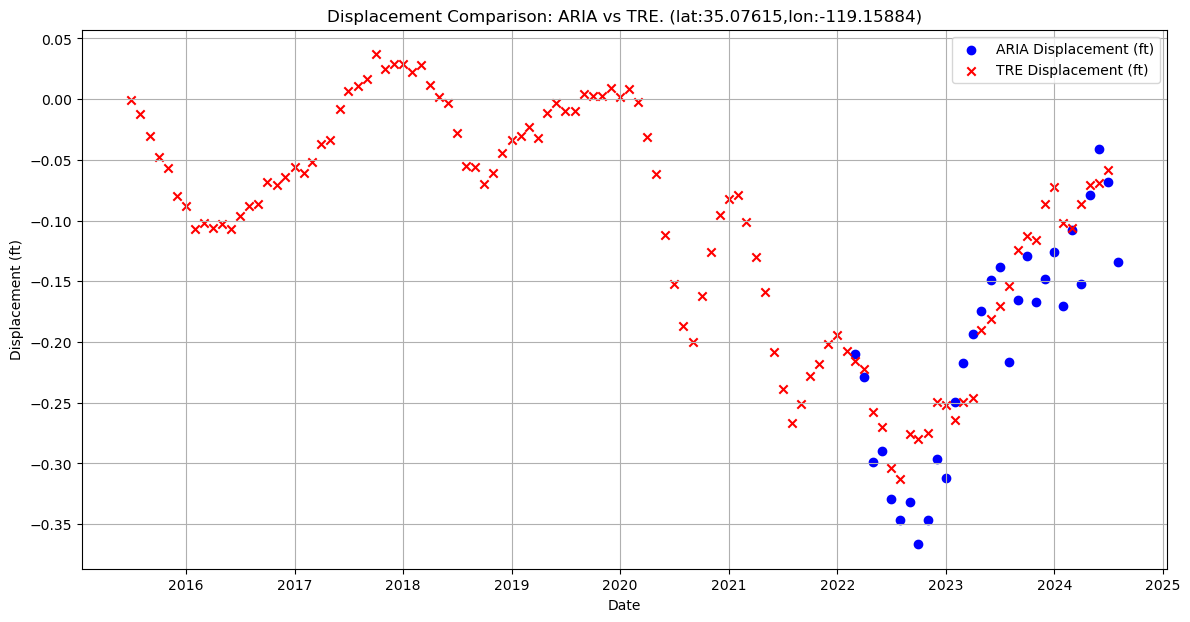

In [9]:
plt.figure(figsize=(14, 7))

# Scatter plot for ARIA data
plt.scatter(ARIA_monthly_mean['date'], ARIA_monthly_mean['displacement_ft_adj'], label='ARIA Displacement (ft)', color='blue', marker='o')

# Scatter plot for TRE data
plt.scatter(TRE['date'], TRE['displacement_ft'], label='TRE Displacement (ft)', color='red', marker='x')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Displacement (ft)')
plt.title('Displacement Comparison: ARIA vs TRE. (lat:{},lon:{})'.format(lat,lon))
plt.legend()
plt.grid()
plt.savefig('TRE_vs_ARIA_{}_{}.png'.format(lat,lon),dpi=500,bbox_inches='tight',transparent=True)

,date,displacement_ft,displacement_ft_adj
0,2022-03-19,0.000000,-0.283000
1,2022-03-31,0.012722,-0.270278
2,2022-04-12,-0.009412,-0.292412
3,2022-04-24,-0.014634,-0.297634
4,2022-05-06,-0.058390,-0.341390
...,...,...,...
65,2024-05-31,0.042208,-0.240792
66,2024-06-12,0.033743,-0.249257
67,2024-07-06,0.060077,-0.222923
68,2024-07-18,0.031532,-0.251468
